# **Purpose**

...multilabel classification with multiple modalities...

# **Imports & Settings**

In [1]:
from utils_models import *
from utils_dataloaders import *
from utils_training import *
from models_classification import *

import json
import glob
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

import torch
from torch.utils.data import DataLoader
import torch.optim as optim

##### set dataframe display options 
# show decimal format (not scientific notation)
pd.options.display.float_format = '{:.4f}'.format

# display all columns
pd.set_option('display.max_columns', None)

c:\Users\mamass1\AppData\Local\miniconda3\envs\cs612\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#####################
# Confirm GPU Status
#####################

if torch.cuda.is_available():
    print('GPU available...')
else:
    print('GPU NOT available...')

GPU available...


# **Parameters**

In [4]:
##########################
# Setup Patches Directory
##########################

model_name = 'ResNext50_03'

# directory for model output
model_dir = f"../models/classification/{model_name}"
if not os.path.isdir(model_dir):
    os.makedirs(model_dir)
else:
    print('DIrectory already exists!!!\nChange directory or will be Overwritten!!!')


# paths to patch GeoJSONs
train_patch_path = r'../models/patches/warren_patches_train.geojson'
val_patch_path = r'../models/patches/warren_patches_val.geojson'
test_patch_path = r'../models/patches/warren_patches_test.geojson'
hardin_test_patch_path = r'../models/patches/hardin_patches_test.geojson'


# directories where patches are stored...
patch_dir = r'../data/patches_warren'
hardin_patch_dir = r'../data/patches_hardin'


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 32
num_epochs = 50
out_classes = 7


# modalities to use (names with unique identifier filename substrings)...
modalities = {
    'dem': ['dem.tif'], 
    # 'rgb': ['aerialr.tif', 'aerialg.tif', 'aerialb.tif'], 
    }


# model = FullModel(out_classes=out_classes, modality_channels=modality_channels).to(device)
encoders = {
    'dem' : ResNextEncoder(input_channels=1)
    }

attentions = {
    'self_dem' : (SelfAttentionBlock(), ['dem'])
    }

model = ClassificationModel(encoders=encoders, attentions=attentions).to(device)

optimizer = optim.Adam(model.parameters())



# focal loss...
reduction = 'mean'
# reduction = 'sum'

gamma = 1

# alpha...
# no class weights
# alpha = 1    

# weighted by class frequency
# read in binary labels
target_path = glob.glob(r'../data/warren/*_labels.csv')[0]
targets = pd.read_csv(target_path)
targets = targets.iloc[:, 1:]

# calculate inverse class frequency
alpha = (len(targets) * targets.shape[1]) / targets.sum(axis=0).to_numpy()

# square root of inverse frequencies
alpha = np.sqrt(alpha)

# normalize weights so they sum to 1
# alpha = alpha / alpha.sum()

# convert to tensor
alpha = torch.tensor(alpha, dtype=torch.float32).view(1, -1).to(device)

# use focal loss
criterion = FocalLoss(alpha=alpha, gamma=gamma, reduction=reduction).to(device)


DIrectory already exists!!!
Change directory or will be Overwritten!!!


In [5]:
# normalization parameters
norm_stats_path = r'../data/warren/image_stats.csv'
df = pd.read_csv(norm_stats_path)
norm_params = {}
for modality, channels in modalities.items():
    means = []
    stds = []
    for channel in channels:
        stats = df.loc[df['path']==channel]
        means.append(stats['mean'].item())
        stds.append(stats['std'].item())
    norm_params[modality] = [means, stds]


In [6]:
metadata = {}
metadata['name'] = model_name
metadata['path'] = model_dir

metadata['training'] = (train_patch_path, patch_dir)
metadata['validation'] = (val_patch_path, patch_dir)
metadata['testing'] = (test_patch_path, patch_dir)
metadata['external testing'] = [(hardin_test_patch_path, hardin_patch_dir) if not hardin_test_patch_path is None else None]

metadata['modalities'] = modalities
metadata['normalizations'] = norm_params

metadata['batch size'] = batch_size
metadata['epochs'] = num_epochs

metadata['optimizer'] = {
    "name": type(optimizer).__name__,
    "learning_rate": optimizer.param_groups[0]['lr'],
    "weight_decay": optimizer.param_groups[0].get('weight_decay', None),
    "momentum": optimizer.param_groups[0].get('momentum', None)
    }
metadata['loss'] = type(criterion).__name__
metadata['FL alpha'] = alpha.cpu().numpy().tolist() if alpha is not None else None
# metadata['FL alpha'] = alpha if alpha is not None else None

metadata['FL gamma'] = gamma if gamma is not None else None

metadata['encoders'] = {key: type(value).__name__ for key, value in encoders.items()}
metadata['attention'] = {key: type(value[0]).__name__ for key, value in attentions.items()}
metadata['model'] = type(model).__name__
metadata['output classes'] = out_classes

with open(f"{model_dir}/metadata.json", 'w') as f:
    json.dump(metadata, f, indent=4)

# **DataLoaders**

In [7]:
#########################################################################
# Setup Custom Datasets and DataLoaders for Train, Validation, Test Sets
#########################################################################

##### get lists of training, validation, and test patch IDs
# training...
gdf_train = gpd.read_file(train_patch_path)
train_ids = gdf_train['patch_id'].to_list()

# validation...
gdf_val = gpd.read_file(val_patch_path)
val_ids = gdf_val['patch_id'].to_list()

# testing (Warren County)...
gdf_test = gpd.read_file(test_patch_path)
test_ids = gdf_test['patch_id'].to_list()

# testing (Hardin County)...
gdf_hardin_test = gpd.read_file(hardin_test_patch_path)
hardin_test_ids = gdf_hardin_test['patch_id'].to_list()


##### create custom datasets
train_dataset = MultiModalDataset(ids=train_ids, 
                                  data_dir=patch_dir, 
                                  modalities=modalities, 
                                  norm_params=norm_params, 
                                  augment=True, 
                                  task='classification')

val_dataset = MultiModalDataset(ids=val_ids, 
                                data_dir=patch_dir, 
                                modalities=modalities, 
                                norm_params=norm_params, 
                                augment=False, 
                                task='classification')

test_dataset = MultiModalDataset(ids=test_ids, 
                                 data_dir=patch_dir, 
                                 modalities=modalities, 
                                 norm_params=norm_params, 
                                 augment=False, 
                                 task='classification')

hardin_test_dataset = MultiModalDataset(ids=hardin_test_ids, 
                                        data_dir=hardin_patch_dir, 
                                        modalities=modalities, 
                                        norm_params=norm_params, 
                                        augment=False, 
                                        task='classification')

#### create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=4, pin_memory=True)
hardin_test_loader = DataLoader(hardin_test_dataset, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=4, pin_memory=True)

## *DataLoader Example*

In [9]:
##################
# Verify Contents
##################

# extract example
example = next(iter(train_loader))

##### print data report
for modality in example.keys():
    print(modality)
    print(f"{type(example[modality])}  |  {example[modality].dtype}  |  {example[modality].shape}  |  {example[modality].min()}  |  {example[modality].max()}")


label
<class 'torch.Tensor'>  |  torch.float32  |  torch.Size([32, 1, 7])  |  0.0  |  1.0
dem
<class 'torch.Tensor'>  |  torch.float32  |  torch.Size([32, 1, 256, 256])  |  -2.069713592529297  |  2.782518148422241


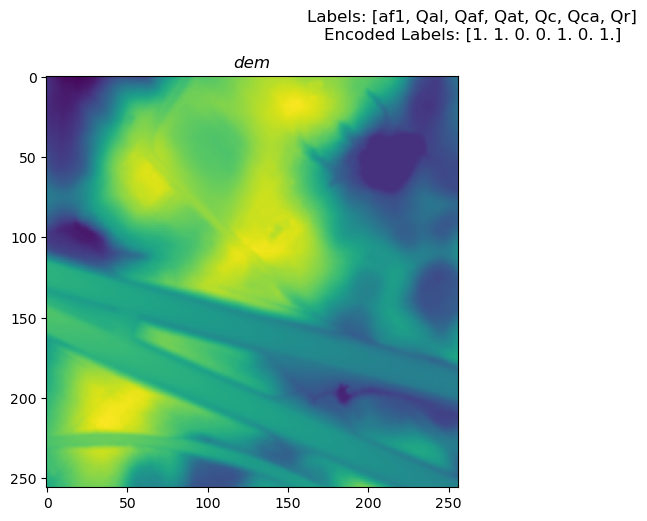

In [15]:
####################
# Visualize Example
####################

##### plot modalities & labels
ncols = 2
nrows = 1
uneven = len(modalities) % ncols
if len(modalities) > ncols:
    if not uneven:
        nrows = len(modalities) / ncols
    else:
        nrows = (len(modalities) // ncols) + 1

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 5*nrows))
ax = ax.ravel()

idx = 0
for modality in example.keys():
    if not 'label' in modality:
        image = prep_image_for_plot(example[modality][0])
        ax[idx].imshow(image)
        ax[idx].set_title(modality, style='italic')
        idx += 1
    else:
        label_vec = example['label'][0].numpy().ravel()

if uneven:
    fig.delaxes(ax[-1])

plt.suptitle(f"Labels: [af1, Qal, Qaf, Qat, Qc, Qca, Qr]\nEncoded Labels: {label_vec}", y=1)
plt.tight_layout()
plt.show()

# **Model**

## *Training*

In [ ]:
########################
# Training & Validation
#######################

##### train
train_loss, train_acc, val_loss, val_acc, best_model = train_model(model, train_loader,  val_loader, criterion, optimizer, device, num_epochs, model_dir)

Epoch 1/50
TRAINING   -- Loss: 1.0059  |  Accuracy: 80.57%  |  Time: 4.67 mins.
VALIDATION -- Loss: 0.9560  |  Accuracy: 82.65%  |  Time: 0.58 mins.
New best model saved with loss 0.9560...
New best model saved with accuracy 82.65%...


Epoch 2/50
TRAINING   -- Loss: 0.9135  |  Accuracy: 82.15%  |  Time: 4.95 mins.
VALIDATION -- Loss: 0.9078  |  Accuracy: 82.70%  |  Time: 0.45 mins.
New best model saved with loss 0.9078...
New best model saved with accuracy 82.70%...


Epoch 3/50
TRAINING   -- Loss: 0.8817  |  Accuracy: 83.03%  |  Time: 4.52 mins.
VALIDATION -- Loss: 0.8993  |  Accuracy: 83.52%  |  Time: 0.47 mins.
New best model saved with loss 0.8993...
New best model saved with accuracy 83.52%...


Epoch 4/50
TRAINING   -- Loss: 0.8716  |  Accuracy: 83.16%  |  Time: 4.75 mins.
VALIDATION -- Loss: 0.8981  |  Accuracy: 82.85%  |  Time: 0.57 mins.
New best model saved with loss 0.8981...


Epoch 5/50
TRAINING   -- Loss: 0.8549  |  Accuracy: 83.64%  |  Time: 4.55 mins.
VALIDATION -- Los

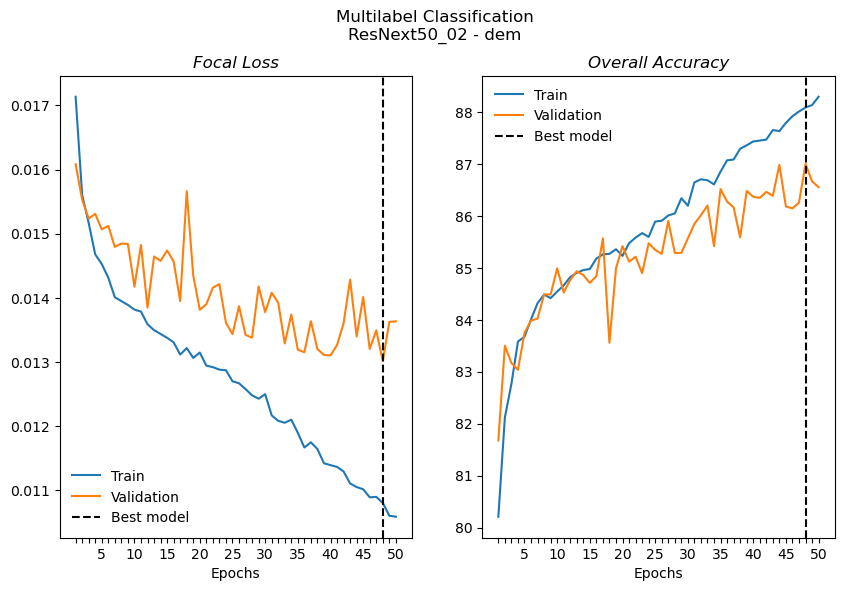

In [7]:
#############################
# Visualize Training Results
#############################

fig, ax = plt.subplots(ncols=2, figsize=(10,6))

epochs = range(1, len(train_loss)+1)

ax[0].plot(epochs, train_loss, label='Train')
ax[0].plot(epochs, val_loss, label='Validation')
ax[0].set_title('Focal Loss', style='italic')

ax[1].plot(epochs, train_acc, label='Train')
ax[1].plot(epochs, val_acc, label='Validation')
ax[1].set_title('Overall Accuracy', style='italic')

for axes in ax:
    axes.axvline(x=best_model, linestyle='--', color='k', label='Best model')
    axes.legend(frameon=False)
    axes.set_xticks(epochs)
    axes.set_xticklabels([str(x) if x%5==0 else '' for x in epochs])
    axes.set_xlabel('Epochs')

modalities_str = list(modalities.keys())[0]
if len(modalities.keys()) > 1:
    for modality in list(modalities.keys())[1:]:
        modalities_str = modalities_str + ' + ' + str(modality)

plt.suptitle(f"Multilabel Classification\n{model_name} - {modalities_str}", y=0.99)
plt.savefig(f"{model_dir}/training_results.jpg")
plt.show()


## *Tuning*

In [26]:
##################
# Load Best Model
##################

# load state dictionary of best model
# state_dict = torch.load(f"{model_dir}/best_loss.pth", map_location=device, weights_only=False)

model_dir = r'../models/classification/ResNext50_01'
state_dict = torch.load(f"{model_dir}/best_loss.pth", map_location=device, weights_only=False)

# load model with best weights
model.load_state_dict(state_dict)

<All keys matched successfully>

In [27]:
###########################################
# Calculate Optimal Thresholds for Max. F1
###########################################

# calculate optimal thresholds from validation set
optimal_thresholds = calculate_optimal_thresholds(model, val_loader, device)

c:\Users\mamass1\Documents\GitHub\cs612\code\utils_training.py:333: RuntimeWarning: invalid value encountered in divide
  


## *Inference*

In [17]:
# def calculate_global_metrics(targets, predictions, thresholds=[0.5]):

#   if len(thresholds) > 1:
#     predictions_binary = predictions
#     for idx, thresh in enumerate(thresholds):
#       predictions_binary[:, idx] = (predictions_binary[:, idx] >= thresh).astype(int)

#   else:
#     predictions_binary = (predictions >= thresholds).astype(int)
  
#   macro_precision = precision_score(targets, predictions_binary, average='macro')
#   macro_recall = recall_score(targets, predictions_binary, average='macro')
#   macro_f1 = f1_score(targets, predictions_binary, average='macro')
#   macro_mAP = average_precision_score(targets, predictions, average='macro')
  
#   weighted_precision = precision_score(targets, predictions_binary, average='weighted')
#   weighted_recall = recall_score(targets, predictions_binary, average='weighted')
#   weighted_f1 = f1_score(targets, predictions_binary, average='weighted')
#   weighted_mAP = average_precision_score(targets, predictions, average='weighted')
  
#   h_loss = hamming_loss(targets, predictions_binary)
#   subset_acc = accuracy_score(targets, predictions_binary)

#   return macro_precision, weighted_precision, macro_recall, weighted_recall, macro_f1, weighted_f1, macro_mAP, weighted_mAP, h_loss, subset_acc

### Warren County Test Set

In [28]:
############################
# Make Test Set Predictions
############################

# get predictions and targets from warren test set
all_predictions, all_targets = test_model(model, test_loader, device)

In [29]:
################################
# Per Label Performance Metrics
################################

df = pd.DataFrame(columns=['Class', 'Targets', 'Predictions', 'Precision', 'Recall', 'F1', 'AP', 'AUROC'])

for idx, (unit, thresh) in enumerate(zip(['af1', 'Qal', 'Qaf', 'Qat', 'Qc', 'Qca', 'Qr'], optimal_thresholds)):
    df.loc[idx, 'Class'] = unit + f" ({str(round(thresh, 2))})"
    preds = all_predictions[:, idx]
    targs = all_targets[:, idx]
    precision, recall, f1, auc_roc = calculate_label_precision_recall_f1_aucroc(preds, targs, threshold=thresh)
    ap = average_precision_score(targs, preds)
    df.loc[idx, 'Targets'] = int(targs.sum())
    df.loc[idx, 'Predictions'] = (preds >= thresh).sum()
    df.loc[idx, 'Precision'] = precision
    df.loc[idx, 'Recall'] = recall
    df.loc[idx, 'F1'] = f1
    df.loc[idx, 'AP'] = ap
    df.loc[idx, 'AUROC'] = auc_roc
df.to_csv(f"{model_dir}/label_metrics_tuned.csv", index=False)
df.head(10)

,Class,Targets,Predictions,Precision,Recall,F1,AP,AUROC
0,af1 (0.43),571,527,0.6243,0.5762,0.5993,0.6940,0.7589
1,Qal (0.44),949,1085,0.7438,0.8504,0.7935,0.8783,0.8030
2,Qaf (0.35),13,5,0.2000,0.0769,0.1111,0.1076,0.8758
3,Qat (0.37),61,79,0.1899,0.2459,0.2143,0.2327,0.8961
4,Qc (0.48),749,756,0.8823,0.8905,0.8864,0.9671,0.9655
5,Qca (0.35),432,556,0.6673,0.8588,0.7510,0.8663,0.9337
6,Qr (0.46),1433,1497,0.9439,0.9860,0.9645,0.9942,0.9239


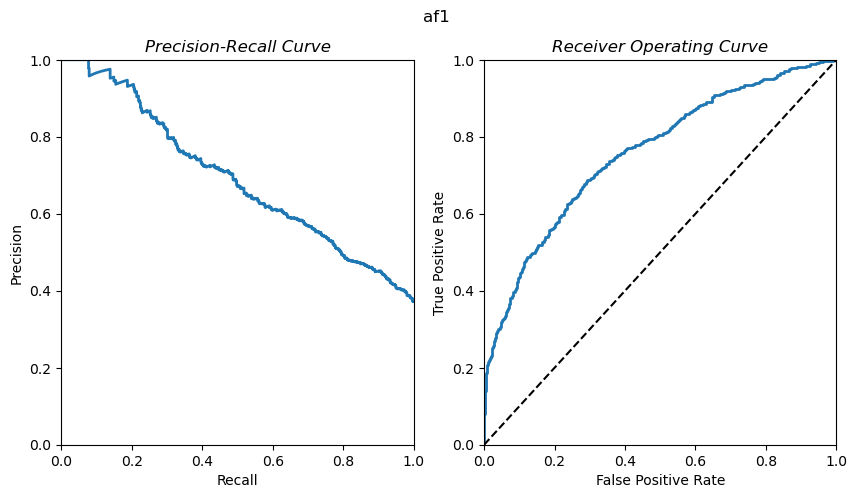

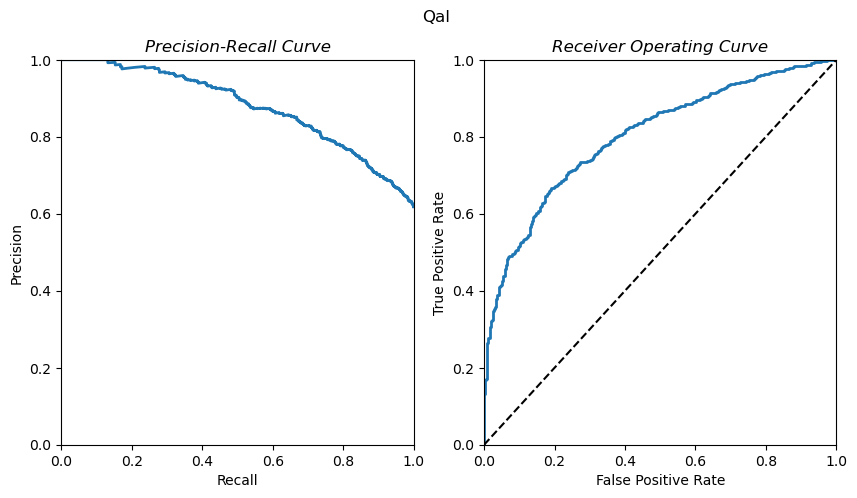

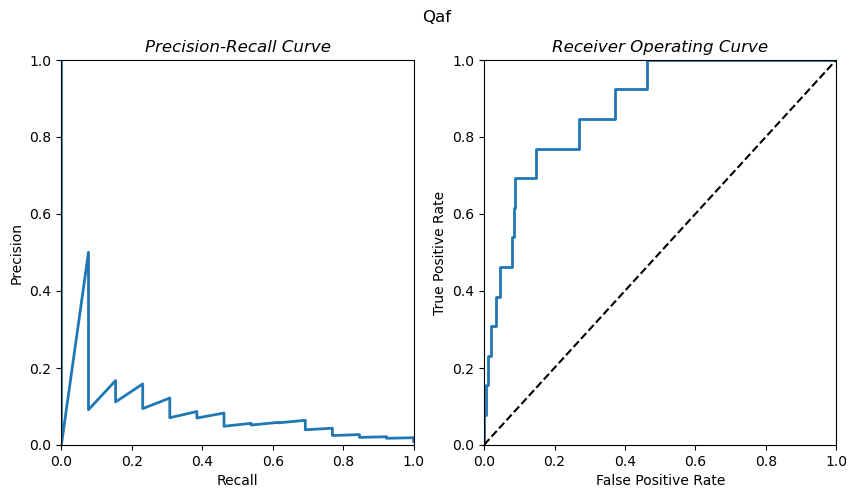

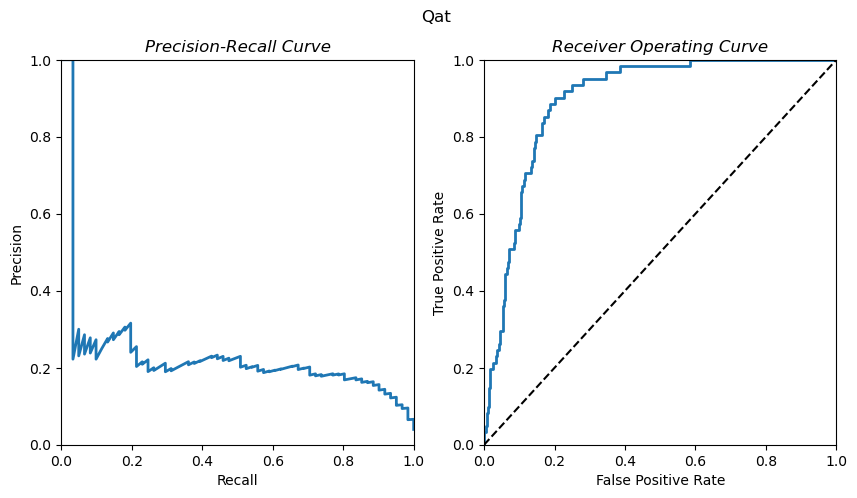

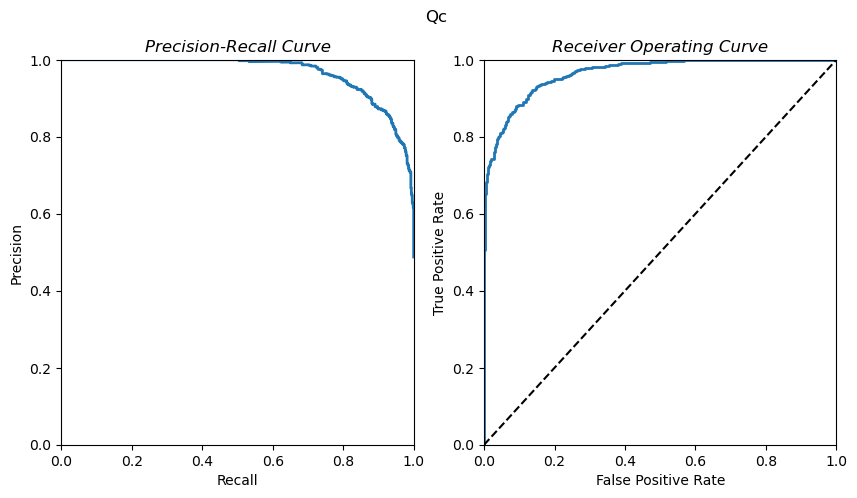

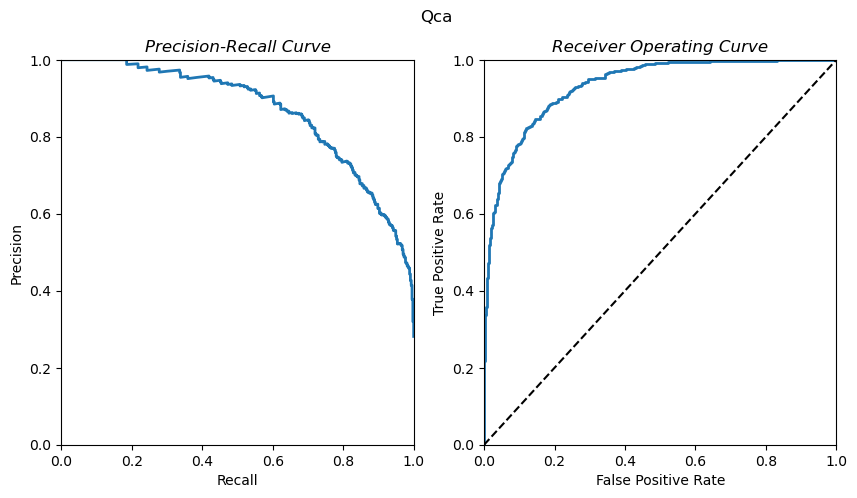

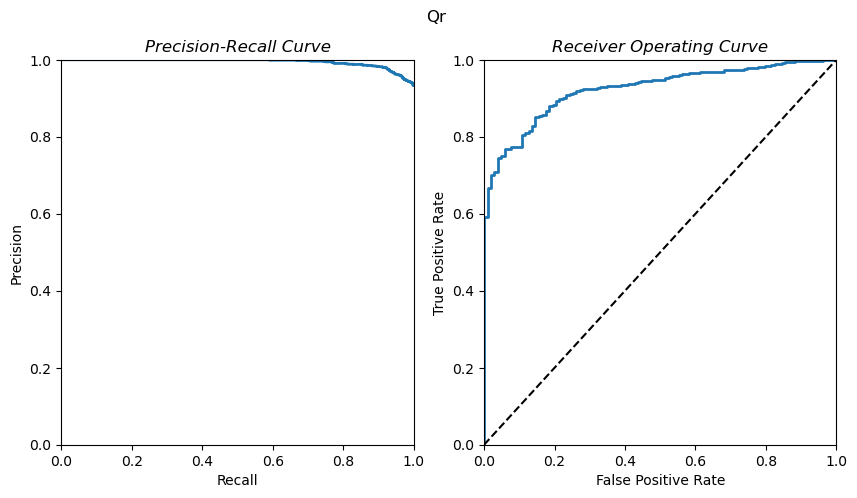

In [30]:
################################
# Precision-Recall & ROC Curves
################################

for idx, unit in enumerate(['af1', 'Qal', 'Qaf', 'Qat', 'Qc', 'Qca', 'Qr']):

    fig = plot_label_pr_roc_curves(all_predictions[:, idx], all_targets[:, idx])
    plt.suptitle(unit)
    fig.savefig(f"{model_dir}/{unit}_pr_roc_curves.jpg")
    plt.show(fig)

In [31]:
#############################
# Global Performance Metrics
#############################

macro_precision, weighted_precision, macro_recall, weighted_recall, macro_f1, weighted_f1, macro_mAP, weighted_mAP, h_loss, subset_acc = calculate_global_metrics(all_targets, all_predictions, thresholds=optimal_thresholds)

df = pd.DataFrame({'Macro Precision': macro_precision, 
                    'Weighted Precision': weighted_precision, 
                    'Macro Recall': macro_recall, 
                    'Weighted Recall': weighted_recall,
                    'Macro F1': macro_f1, 
                    'Weighted F1': weighted_f1, 
                    'Macro mAP': macro_mAP, 
                    'Weighted mAP': weighted_mAP, 
                    'Hamming Loss': h_loss, 
                    'Subset Accuracy':subset_acc}, index=[0])

df.to_csv(f"{model_dir}/global_metrics_tuned.csv", index=False)
df.head()

,Macro Precision,Weighted Precision,Macro Recall,Weighted Recall,Macro F1,Weighted F1,Macro mAP,Weighted mAP,Hamming Loss,Subset Accuracy
0,0.6073,0.8028,0.6407,0.8562,0.6172,0.8270,0.5339,0.7685,0.1402,0.3125


### Hardin County Test Set

In [32]:
############################
# Make Test Set Predictions
############################

# get predictions and targets from warren test set
all_predictions, all_targets = test_model(model, hardin_test_loader, device)

In [33]:
################################
# Per Label Performance Metrics
################################

df = pd.DataFrame(columns=['Class', 'Targets', 'Predictions', 'Precision', 'Recall', 'F1', 'AP', 'AUROC'])

for idx, (unit, thresh) in enumerate(zip(['af1', 'Qal', 'Qaf', 'Qat', 'Qc', 'Qca', 'Qr'], optimal_thresholds)):
    df.loc[idx, 'Class'] = unit + f" ({str(round(thresh, 2))})"
    preds = all_predictions[:, idx]
    targs = all_targets[:, idx]
    precision, recall, f1, auc_roc = calculate_label_precision_recall_f1_aucroc(preds, targs, threshold=thresh)
    ap = average_precision_score(targs, preds)
    df.loc[idx, 'Targets'] = int(targs.sum())
    df.loc[idx, 'Predictions'] = (preds >= thresh).sum()
    df.loc[idx, 'Precision'] = precision
    df.loc[idx, 'Recall'] = recall
    df.loc[idx, 'F1'] = f1
    df.loc[idx, 'AP'] = ap
    df.loc[idx, 'AUROC'] = auc_roc
df.to_csv(f"{model_dir}/label_metrics_tuned_hardin.csv", index=False)
df.head(10)

,Class,Targets,Predictions,Precision,Recall,F1,AP,AUROC
0,af1 (0.43),435,1037,0.3047,0.7264,0.4293,0.3342,0.5609
1,Qal (0.44),845,1215,0.5597,0.8047,0.6602,0.5803,0.5079
2,Qaf (0.35),6,0,0.0000,0.0000,0.0000,0.0099,0.6667
3,Qat (0.37),77,0,0.0000,0.0000,0.0000,0.0427,0.4257
4,Qc (0.48),456,848,0.5295,0.9846,0.6887,0.8963,0.9505
5,Qca (0.35),249,474,0.4557,0.8675,0.5975,0.7121,0.9136
6,Qr (0.46),1511,1535,0.9837,0.9993,0.9915,0.9932,0.7129


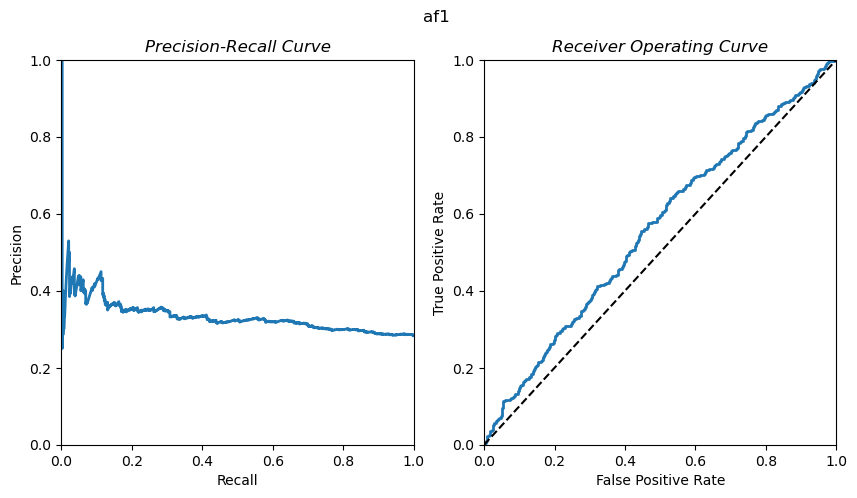

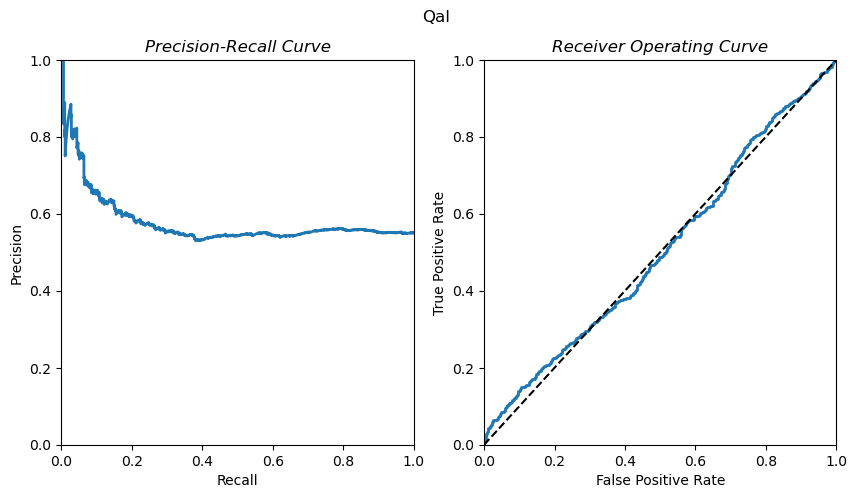

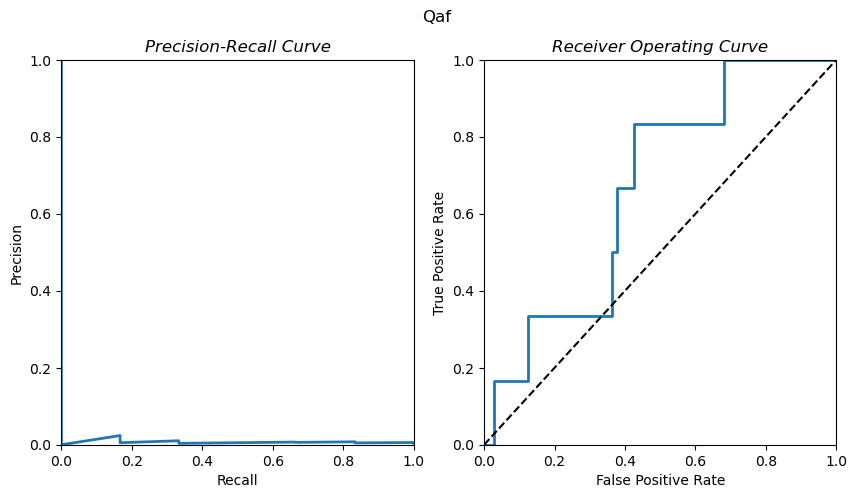

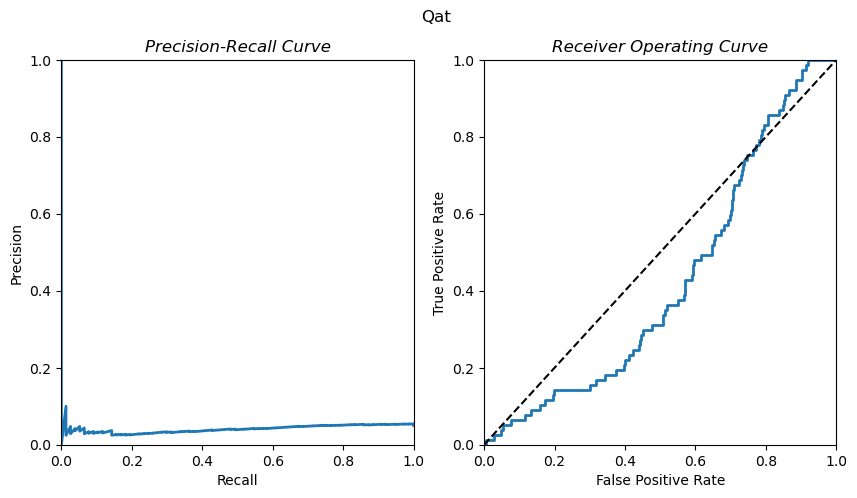

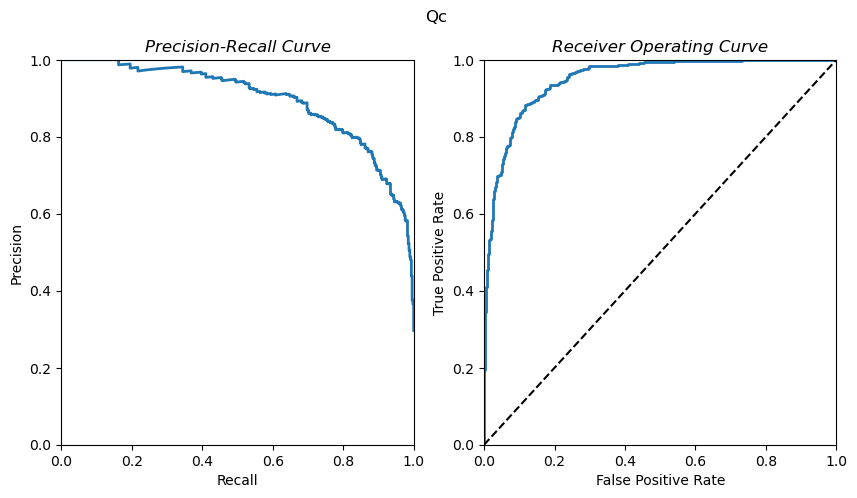

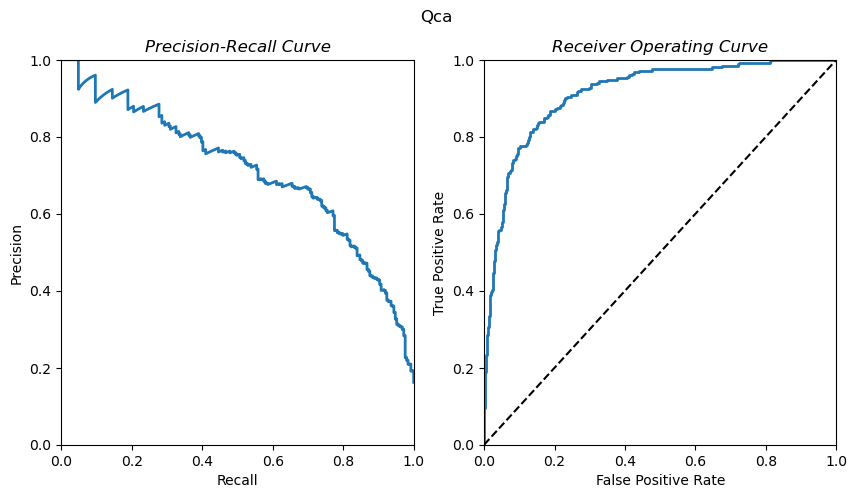

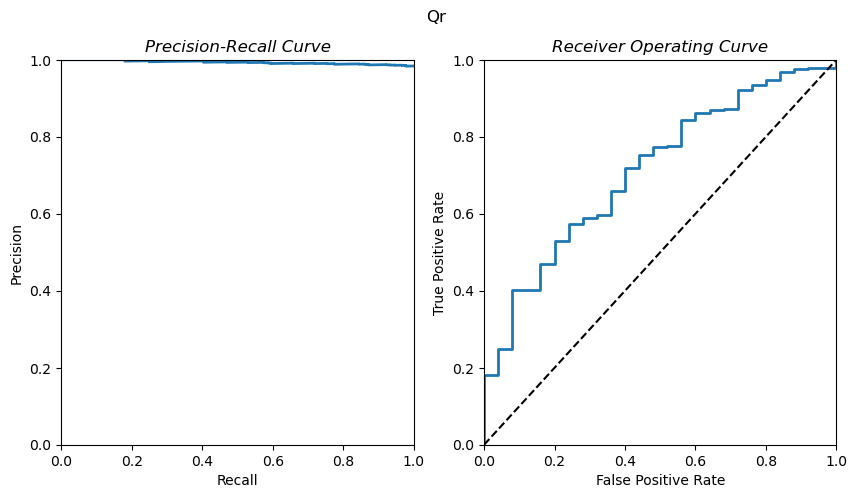

In [34]:
################################
# Precision-Recall & ROC Curves
################################

for idx, unit in enumerate(['af1', 'Qal', 'Qaf', 'Qat', 'Qc', 'Qca', 'Qr']):

    fig = plot_label_pr_roc_curves(all_predictions[:, idx], all_targets[:, idx])
    plt.suptitle(unit)
    fig.savefig(f"{model_dir}/{unit}_pr_roc_curves_hardin.jpg")
    plt.show(fig)

In [35]:
#############################
# Global Performance Metrics
#############################

macro_precision, weighted_precision, macro_recall, weighted_recall, macro_f1, weighted_f1, macro_mAP, weighted_mAP, h_loss, subset_acc = calculate_global_metrics(all_targets, all_predictions, thresholds=optimal_thresholds)

df = pd.DataFrame({'Macro Precision': macro_precision, 
                    'Weighted Precision': weighted_precision, 
                    'Macro Recall': macro_recall, 
                    'Weighted Recall': weighted_recall,
                    'Macro F1': macro_f1, 
                    'Weighted F1': weighted_f1, 
                    'Macro mAP': macro_mAP, 
                    'Weighted mAP': weighted_mAP, 
                    'Hamming Loss': h_loss, 
                    'Subset Accuracy':subset_acc}, index=[0])

df.to_csv(f"{model_dir}/global_metrics_tuned_hardin.csv", index=False)
df.head()

c:\Users\mamass1\AppData\Local\miniconda3\envs\cs612\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mamass1\AppData\Local\miniconda3\envs\cs612\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Macro Precision,Weighted Precision,Macro Recall,Weighted Recall,Macro F1,Weighted F1,Macro mAP,Weighted mAP,Hamming Loss,Subset Accuracy
0,0.4048,0.6836,0.6261,0.8860,0.4810,0.7559,0.4053,0.6804,0.2182,0.1374


In [ ]:
# parameters...
# output_dir = r'../models/classification/model_01'
# out_classes = 7
# modality_channels = {'rgb': 3, 'dem': 1}
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = FullModel(out_classes=out_classes, modality_channels=modality_channels).to(device)
# state_dict = torch.load(f"{model_dir}/best_loss.pth", map_location=device, weights_only=False)
# model.load_state_dict(state_dict)

In [18]:
# all_predictions, all_targets = test_model(model, test_loader, device)

In [ ]:
# df = pd.DataFrame(columns=['Class', 'Targets', 'Predictions', 'Precision', 'Recall', 'F1', 'AUROC'])

# for idx, unit in enumerate(['af1', 'Qal', 'Qaf', 'Qat', 'Qc', 'Qca', 'Qr']):
#     df.loc[idx, 'Class'] = unit
#     preds = all_predictions[:, idx]
#     targs = all_targets[:, idx]
#     precision, recall, f1, auc_roc = calculate_label_precision_recall_f1_aucroc(preds, targs, threshold=0.5)
#     df.loc[idx, 'Targets'] = int(targs.sum())
#     df.loc[idx, 'Predictions'] = (preds >= 0.5).sum()
#     df.loc[idx, 'Precision'] = precision
#     df.loc[idx, 'Recall'] = recall
#     df.loc[idx, 'F1'] = f1
#     df.loc[idx, 'AUROC'] = auc_roc
# df.to_csv(f"{model_dir}/label_metrics.csv", index=False)
# df.head(10)


In [ ]:
# ##### Visualizations - Precision-Recall Curve & ROC Curve

# for idx, unit in enumerate(['af1', 'Qal', 'Qaf', 'Qat', 'Qc', 'Qca', 'Qr']):

#     fig = plot_label_pr_roc_curves(all_predictions[:,idx], all_targets[:, idx])
#     plt.suptitle(unit)
#     fig.savefig(f"{model_dir}/{unit}_pr_roc_curves.jpg")
#     plt.show(fig)


In [ ]:
# ##### Averaged over all labels - Precision, Recall, F1, AUC-ROC, & mean Average Precision (mAP), Hamming loss, Subset Accuracy
# macro_precision, macro_recall, macro_f1, mean_ap, h_loss, subset_acc = calculate_global_metrics(all_targets, all_predictions, thresholds=[0.5])

# df = pd.DataFrame({'Macro Precision': macro_precision, 
#                    'Macro Recall': macro_recall, 
#                    'Macro F1': macro_f1, 
#                    'mAP': mean_ap, 
#                    'Hamming Loss': h_loss, 
#                    'Subset Accuracy':subset_acc}, index=[0])

# df.to_csv(f"{model_dir}/global_metrics.csv", index=False)
# df.head()

In [28]:
# def calculate_optimal_thresholds(model, val_loader, device):
  
#   all_predictions = []
#   all_targets = []

#   model.eval()

#   with torch.no_grad():
#     for batch in val_loader:
      
#       labels = batch.pop('label').squeeze(1).to(device)
#       modalities = {modality: data.to(device) for modality, data in batch.items()}
#       outputs = model(modalities)
#       predictions = torch.sigmoid(outputs)
#       all_targets.append(labels.cpu().numpy())
#       all_predictions.append(predictions.cpu().numpy())
  
#   all_predictions = np.concatenate(all_predictions)
#   all_targets = np.concatenate(all_targets)

#   optimal_thresholds = []

#   for class_idx in range (all_predictions.shape[1]):
#     precision, recall, thresholds = precision_recall_curve(all_targets[:, class_idx], all_predictions[:, class_idx])
#     f1 = 2 * (precision * recall) / (precision + recall)
#     best_idx = np.argmax(f1)
#     best_threshold = thresholds[best_idx]
#     optimal_thresholds.append(best_threshold)

#   return optimal_thresholds

In [ ]:
# optimal_thresholds = calculate_optimal_thresholds(model, val_loader, device)
# optimal_thresholds

In [ ]:
# df = pd.DataFrame(columns=['Class', 'Targets', 'Predictions', 'Precision', 'Recall', 'F1', 'AUROC'])

# for idx, (unit, thresh) in enumerate(zip(['af1', 'Qal', 'Qaf', 'Qat', 'Qc', 'Qca', 'Qr'], optimal_thresholds)):
#     df.loc[idx, 'Class'] = unit + f" ({str(round(thresh, 2))})"
#     preds = all_predictions[:, idx]
#     targs = all_targets[:, idx]
#     precision, recall, f1, auc_roc = calculate_label_precision_recall_f1_aucroc(preds, targs, threshold=thresh)
#     df.loc[idx, 'Targets'] = int(targs.sum())
#     df.loc[idx, 'Predictions'] = (preds >= thresh).sum()
#     df.loc[idx, 'Precision'] = precision
#     df.loc[idx, 'Recall'] = recall
#     df.loc[idx, 'F1'] = f1
#     df.loc[idx, 'AUROC'] = auc_roc
# df.to_csv(f"{model_dir}/label_metrics_tuned.csv", index=False)
# df.head(10)

In [ ]:
# macro_precision, macro_recall, macro_f1, mean_ap, h_loss, subset_acc = calculate_global_metrics(all_targets, all_predictions, thresholds=optimal_thresholds)

# df = pd.DataFrame({'Macro Precision': macro_precision, 
#                    'Macro Recall': macro_recall, 
#                    'Macro F1': macro_f1, 
#                    'mAP': mean_ap, 
#                    'Hamming Loss': h_loss, 
#                    'Subset Accuracy':subset_acc}, index=[0])

# df.to_csv(f"{model_dir}/global_metrics_tuned.csv", index=False)
# df.head()